# Rastreamento de contato com aprendizado de máquina

O rastreamento de contato é um processo usado pelos ministérios da saúde pública para ajudar a impedir a propagação de doenças infecciosas, como o COVID-19, dentro de uma comunidade. Neste projeto, apresentarei a tarefa de rastreamento de contatos com o aprendizado de máquina.

# Como funciona o rastreamento de contatos de pessoas?
Uma vez que uma pessoa é positiva para coronavírus, é muito importante identificar outras pessoas que possam ter sido infectadas pelos pacientes diagnosticados. Para identificar os infectados, as autoridades acompanham a atividade dos pacientes diagnosticados nos últimos 14 dias. Esse processo é chamado de rastreamento de contato. Dependendo do país e da autarquia local, a procura de contactos realiza-se quer por métodos manuais quer por métodos numéricos.

Neste projeto, irei propor um algoritmo de rastreamento de contato digital que se baseia em dados de GPS, que pode ser usado no rastreamento de contato com aprendizado de máquina.

# Rastreamento de contato com aprendizado de máquina
DBSCAN é um algoritmo de agrupamento de dados baseado em densidade que agrupa pontos de dados em um determinado espaço. O algoritmo DBSCAN agrupa pontos de dados próximos uns dos outros e marca pontos de dados discrepantes como ruído. Vou usar o algoritmo DBSCAN para a tarefa de rastreamento de contatos com Machine Learning.

O conjunto de dados que usarei nesta tarefa são dados JSON. Agora, vamos importar todas as bibliotecas de que precisamos para esta tarefa e começar a ler o conjunto de dados e explorar alguns insights dos dados:

Primeiro, vamos importar todas as bibliotecas que usaremos. Precisaremos do Pandas e do Sklearn para processar os dados e do Pygal para exibi-los.

In [ ]:
!pip install pygal

In [ ]:
import numpy as np
import pandas as pd
import pygal
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.cluster import DBSCAN
df = pd.read_json('livedata.json')
df.head()


,id,timestamp,latitude,longitude
0,David,2020-07-04 15:35:30,13.148953,77.593651
1,David,2020-07-04 16:35:30,13.222397,77.652828
2,Frank,2020-07-04 14:35:30,13.236507,77.693792
3,Carol,2020-07-04 21:35:30,13.163716,77.562842
4,Ivan,2020-07-04 22:35:30,13.232095,77.580273


Agora, vamos analisar o conjunto de dados usando o gráfico de dispersão mostrando os ids com suas latitudes e longitudes no eixo x e no eixo Y, respectivamente:

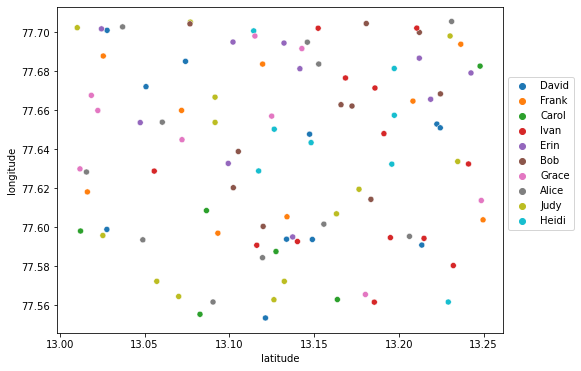

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='latitude', y='longitude', data=df, hue='id')
plt.legend(bbox_to_anchor= [1, 0.8])
plt.show()

# Criando um modelo para rastreamento de contato com aprendizado de máquina
Agora vamos criar um modelo para rastreamento de contato usando o modelo DBSCAN. A função abaixo nos ajudará a criar o modelo DBSCAN, a partir desse modelo geraremos clusters, que ajudarão a identificar infecções filtrando os dados nos clusters:

O algoritmo DBSCAN vê os clusters como áreas de alta densidade separadas por regiões de baixa densidade. Por causa disso, os clusters encontrados pelo DBSCAN podem ter qualquer formato, ao contrário de k-means, que assume que todos os clusters têm formato convexo.

Sklearn tinha um algoritmo DBSCAN predefinido; tudo que você precisa fazer para usá-lo é conhecer três parâmetros:

* eps: Este fator indica a distância entre os diferentes pontos no mesmo cluster. No nosso caso, usaremos a distância recomendada pelo CDC, que é 6 pés (ou 0,0018288 quilômetros).

* min_samples: O número mínimo de amostras no cluster. No caso de conjuntos de dados grandes e barulhentos, aumente esse número.
* métrica: define a métrica de distância entre os pontos de dados. Sklearn tem muitas métricas de distância, como euclidean, manhattan e Minkowski. Para nosso caso, entretanto, precisamos de uma medida de distância que descreva a distância em uma cifra (A Terra). A métrica para isso é chamada de haversine.

Agora podemos aplicar nosso modelo ao conjunto de dados.

In [ ]:
safe_distance = 0.0018288 # uma distância radial de 6 pés em quilômetros
model = DBSCAN(eps=safe_distance, min_samples=2, metric='haversine').fit(df[['latitude', 'longitude']])
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True
labels = model.labels_
df['Cluster'] = model.labels_.tolist()

A aplicação do modelo com esses parâmetros leva a 18 clusters. Podemos exibir esses clusters usando este pedaço de código ...

In [ ]:
# para visualizar os gráficos usando a biblioteca PYGAL, é necessário fazer este código abaixo

from IPython.display import display, HTML
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

In [ ]:
disp_dict_clust = {}
for index, row in df.iterrows():
    if row['Cluster'] not in disp_dict_clust.keys():
        disp_dict_clust[row['Cluster']] = [(row['latitude'], row['longitude'])]
    else:
        disp_dict_clust[row['Cluster']].append((row['latitude'], row['longitude']))
print(len(disp_dict_clust.keys()))
from pygal.style import LightenStyle
dark_lighten_style = LightenStyle('#F35548')
xy_chart = pygal.XY(stroke=False, style=dark_lighten_style)
[xy_chart.add(str(k),v) for k,v in disp_dict_clust.items()]
display(HTML(base_html.format(rendered_chart=xy_chart.render(is_unicode=True))))

Após a conclusão do algoritmo, se houver algum ponto de dados sem cluster, eles serão agrupados como ruído ou cluster -1. Freqüentemente, você descobrirá que todos os usuários neste conjunto de dados farão parte do cluster -1, além de outros clusters.

# Preveja pessoas infectadas.
Se tivermos o nome de uma pessoa infectada, podemos usá-lo para obter todos os clusters dos quais essa pessoa faz parte. A partir daí, podemos ver outras pessoas nesses clusters. Essas pessoas terão uma probabilidade maior de serem infectadas do que aquelas que não o são.

Obtenha todos os clusters aos quais uma pessoa específica pertence
Dado um nome inputName, por exemplo, Frank, queremos todos os clusters dos quais Frank faz parte.

In [ ]:
def contactTracing(dataFrame, inputName):
    #Verifique se o nome é válido
    assert (inputName in df['id'].tolist()), "Usuário não existe"
    #Distância social
    safe_distance = 0.0018288 #6 feets in kilometers
    #Aplique o modelo, no caso de um conjunto de dados maior ou ruidoso, aumente min_samples
    model = DBSCAN(eps=safe_distance, min_samples=10, metric='haversine').fit(df[['latitude', 'longitude']])
    #Obtenha clusters encontrados pelo algoritmo
    labels = model.labels_
    #Adicione os clusters ao dataframe
    df['Cluster'] = model.labels_.tolist()
    #Obtenha os clusters dos quais o inputName faz parte
    inputNameClusters = set()
    for i in range(len(dataFrame)):
        if df['id'][i] == inputName:
            inputNameClusters.add(df['Cluster'][i])
   #Obtenha pessoas que estão no mesmo cluster que o inputName      
    infected = set()
    for cluster in inputNameClusters:
        if cluster != -1: #contanto que não seja o cluster -1
            namesInCluster = df.loc[dataFrame['Cluster'] == cluster, 'id'] #Obtenha todos os nomes do cluster
            for i in range(len(namesInCluster)):
              #localize cada nome no cluster
                name = namesInCluster.iloc[i]
                if name != inputName: #Não quero adicionar a entrada aos resultados
                    infected.add(name)
    print("As infecções potenciais são:",*infected,sep="\n" )




In [ ]:
print(contactTracing(df,'Frank'))

As infecções potenciais são:
None


# Conclusão
Rastreamento de contato de pessoas é uma das maneiras pelas quais podemos usar a tecnologia para salvar a vida das pessoas e fornecer tratamento o mais rápido possível. O governo e os profissionais da área médica freqüentemente têm acesso aos locais de GPS de alguns pacientes. O processo que percorremos neste artigo é fundamentalmente o mesmo que eles seguem para obter infecções em potencial. Felizmente, graças a bibliotecas como Sklearn, podemos usar modelos predefinidos em nossos conjuntos de dados e obter resultados com poucas linhas de código.